In [3]:
from pathlib import Path
import os.path
import inspect

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import mjoanalyses.general_mjo_tools as tools
import predictability_code as romi
import mjoindices.empirical_orthogonal_functions as eof

import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['font.size'] = '16'

In [120]:
def iterate_romi(restart_dates, output_path):
    
    control_romi = []
    restart_romi = []
    
    for r in restart_dates:
        
        control = xr.open_dataarray(output_path + f'twin_restart_{r}/atm/hist/romi_control_{r}.nc')
        restart = xr.open_dataarray(output_path + f'twin_restart_{r}/atm/hist/romi_twin_{r}.nc')
        
        control_romi.append(control)
        restart_romi.append(restart)
        
    return control_romi, restart_romi

In [9]:
color_set = [(102/255,194/255,165/255), 
                  (252/255,141/255,98/255), 
                  (141/255,160/255,203/255)] # https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3

In [10]:
fig_dir = Path(os.path.abspath('')) / 'figures'

In [11]:
output_path = Path('/n/home04/sweidman/cesm_output/')
output_path_str = '/n/home04/sweidman/cesm_output/'
ROMI_data = xr.open_dataset( fig_dir / "ROMI_each_forecast.nc")
restart_dates = list(ROMI_data.restart_date.values)

In [155]:
def plot_pc_diagram(pcs_control, pcs_restart, axs=None):
    """
    Plot phase diagram based on PC amplitude
    
    :param pcs: PC dataframe that includes at least PC1, PC2, and separated day month year columns.
    """
    
    # for creating background grid
    x = np.linspace(-4,4,100)
    y1 = x
    y2 = -x
    t = np.linspace(0,np.pi*2,100)
    
    #fig, axs = plt.subplots(1,1, clear=True, figsize=(6,6))
    if axs is None:
        axs = plt.gca()
    end_idx = 55

    axs.plot(pcs_control.PC2[5:end_idx], -pcs_control.PC1[5:end_idx], 
                      'x--', color=color_set[0], label='Control')
    axs.plot(pcs_restart.PC2[5:end_idx], -pcs_restart.PC1[5:end_idx], 
                      'x-', color=color_set[2], label='Forecast')
    
    axs.plot(pcs_control.PC2.values[5], -pcs_control.PC1.values[5], 
                      color=color_set[0], marker='o', markersize='10')
    axs.plot(pcs_restart.PC2.values[5], -pcs_restart.PC1.values[5], 
                      color=color_set[2], marker='o', markersize='10')
    
    for idx in range(10,end_idx,5):
        axs.plot(pcs_control.PC2.values[idx], -pcs_control.PC1.values[idx], 
                      color=color_set[0], marker='s', markersize='8')
        axs.plot(pcs_restart.PC2.values[idx], -pcs_restart.PC1.values[idx], 
                      color=color_set[2], marker='s', markersize='8')
    
    #axs.legend(loc='lower left')
            
    axs.set_xlabel('PC2')
    axs.set_ylabel('-PC1')

    # create background grid and unit circle
    axs.plot(np.cos(t), np.sin(t), 'grey', linewidth=1, linestyle='dashed')
    axs.plot(x,y1, 'gray', linestyle='dashed')
    axs.plot(x,y2, 'gray', linestyle='dashed')
    axs.hlines(0,x[0],x[-1], 'gray', linestyle='dashed')
    axs.vlines(0,x[0],x[-1], 'gray', linestyle='dashed')

    axs.set_xlim([-4,4])
    axs.set_ylim([-4,4])
    axs.set_box_aspect(1)
    
    axs.set_title(f'Run start: {pcs_control.time[6].dt.strftime("%Y-%m-%d").values}')
    
    #print(f'Plot starts: {pcs_control.time[5].values}')
    print(f'Restart starts: {pcs_control.time[6].values}')
    print(f'Plot ends: {pcs_control.time[end_idx-1].values}')
    
    return axs

In [137]:
example_dates = ['0003-01-21', '0004-01-01', '0001-10-03', '0003-11-22']
control_romi_list, restart_romi_list = iterate_romi(example_dates, output_path_str)

Restart starts: 0003-01-21 00:00:00
Plot ends: 0003-03-10 00:00:00
Restart starts: 0004-01-01 00:00:00
Plot ends: 0004-02-18 00:00:00
Restart starts: 0001-10-03 00:00:00
Plot ends: 0001-11-20 00:00:00
Restart starts: 0003-11-22 00:00:00
Plot ends: 0004-01-09 00:00:00


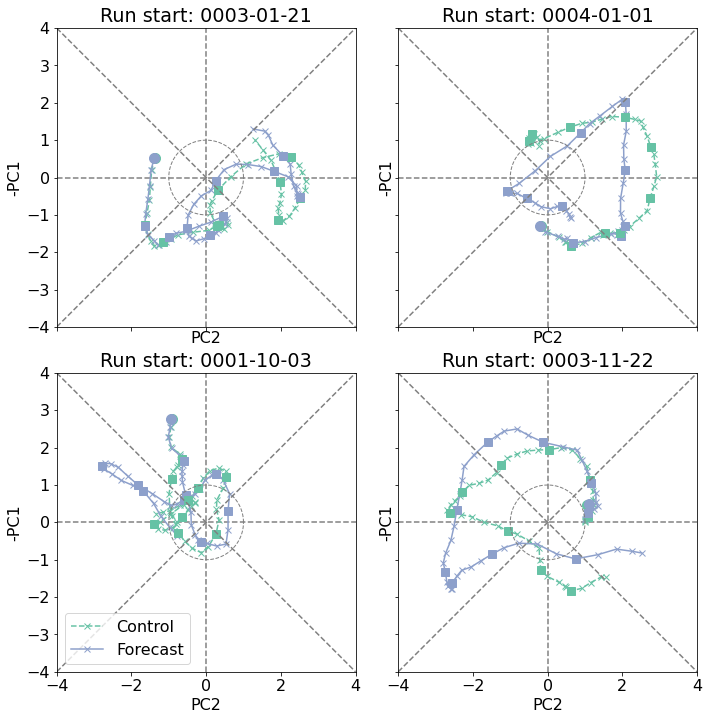

In [159]:
fig,axs = plt.subplots(2,2,figsize=(10,10), sharey = True, sharex=True)
plt.tight_layout()
for i in range(len(control_romi_list)):
    plot_pc_diagram(control_romi_list[i],restart_romi_list[i], axs.flat[i])
axs[1,0].legend(loc='lower left')
#plt.savefig(fig_dir / 'predict_fig2.svg', bbox_inches='tight', format = 'svg', dpi=1200)
#plt.savefig(fig_dir / 'predict_fig2.png', bbox_inches='tight')

In [14]:
# load in EOFs and previously computed OMI
pcs_omi = tools.organize_pc_dataframe('/n/home04/sweidman/MJO_analyses/MJO_indices/PCs/PCs_twin_control_20yrs.txt')
eof_filename = '/n/home04/sweidman/MJO_analyses/MJO_indices/EOFs/EOFs_40spcam_rot.npz'
omi_eofs = eof.restore_all_eofs_from_npzfile(eof_filename)

In [15]:
# create lists of dates by phase and activity
sorted_p, sorted_act = romi.split_restarts_by_phase(restart_dates, output_path, threshold=1.14, threshold_window=0)
active_dates = [item for sublist in sorted_act for item in sublist]
inactive_dates = list(set(restart_dates) - set(active_dates))

In [16]:
# load in acc / rmse based on initial date
all_error = np.load('/n/home04/sweidman/MJO_analyses/figures/all_bicor_800.npy')
act_error = np.load('/n/home04/sweidman/MJO_analyses/figures/act_bicor_800.npy')
inact_error = np.load('/n/home04/sweidman/MJO_analyses/figures/inact_bicor_800.npy')
error_matrix_phase = np.load('/n/home04/sweidman/MJO_analyses/figures/all_phase_bicor_800.npy')
error_matrix_phase_act = np.load('/n/home04/sweidman/MJO_analyses/figures/act_phase_bicor_800.npy')

In [17]:
# load in acc / rmse based on target date
bicor_rmse_info = xr.open_dataset("/n/home04/sweidman/MJO_analyses/figures/bicor_target_800.nc")

In [18]:
# load in mse / signal after running calc_snr.py
mse = np.load('/n/home04/sweidman/MJO_analyses/figures/mse_800.npy')
signal = np.load('/n/home04/sweidman/MJO_analyses/figures/signal_800.npy')

In [19]:
# separate mse and signal into active and inactive dates
idx_active = [r in active_dates for r in restart_dates]
mse_active = mse[:,idx_active]
signal_active = signal[:,idx_active]

idx_inactive = [r in inactive_dates for r in restart_dates]
mse_inactive = mse[:,idx_inactive]
signal_inactive = signal[:, idx_inactive]

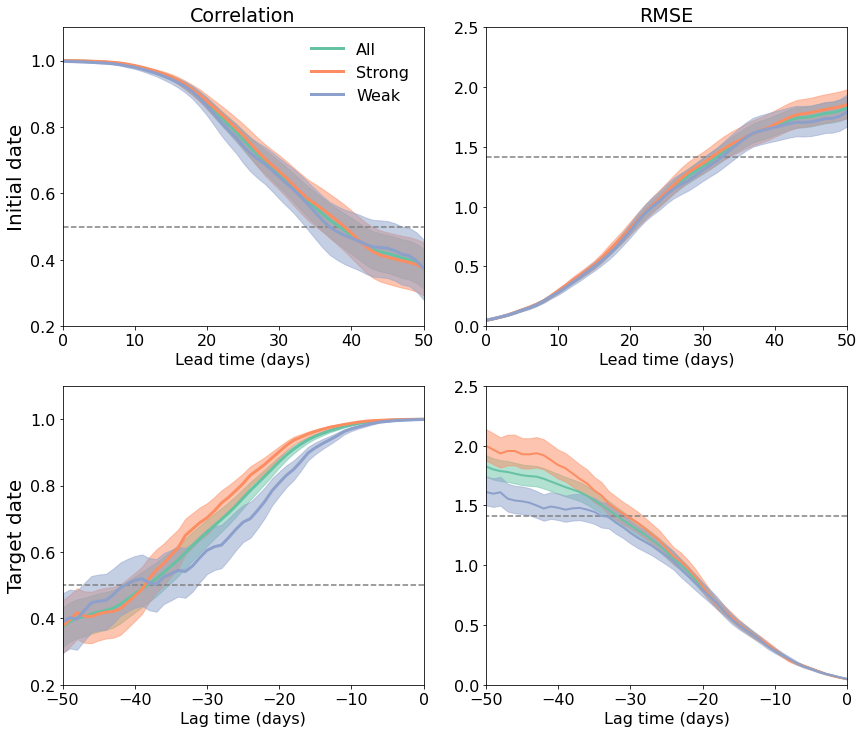

In [171]:
fig,ax = plt.subplots(2,2,figsize=(12,10))
plt.tight_layout()

ax[0,0].plot(all_error[6:-10,0], linewidth=3, color=color_set[0], label='All')
ax[0,0].fill_between(np.arange(0,51), romi.calculate_ci_acc(all_error[6:-10,0],798,133)[0], calculate_ci_acc(all_error[6:-10,0],798,133)[1], color=color_set[0], alpha=0.5)
ax[0,0].plot(act_error[6:-10,0], linewidth=3, color=color_set[1],label='Strong')
ax[0,0].fill_between(np.arange(0,51), romi.calculate_ci_acc(act_error[6:-10,0],450,133)[0], calculate_ci_acc(act_error[6:-10,0],450,133)[1], color=color_set[1], alpha=0.5)
ax[0,0].plot(inact_error[6:-10,0], linewidth=3, color=color_set[2],label='Weak')
ax[0,0].fill_between(np.arange(0,51), romi.calculate_ci_acc(inact_error[6:-10,0],348,133)[0], calculate_ci_acc(inact_error[6:-10,0],348,133)[1], color=color_set[2], alpha=0.5)
ax[0,0].hlines(.5, 0,51, linestyles='--', color='grey')
ax[0,0].set_title('Correlation')
ax[0,0].set_ylim([0.2,1.1])
ax[0,0].set_xlim([0,50])
ax[0,0].set_xlabel('Lead time (days)')
ax[0,0].legend(frameon=False)

ax[0,1].plot(all_error[6:-10,1], linewidth=3, color=color_set[0],label='All')
ax[0,1].fill_between(np.arange(0,51), romi.calculate_ci_rmse(all_error[6:-10,1],798,133)[0], calculate_ci_rmse(all_error[6:-10,1],798,133)[1], color=color_set[0], alpha=0.5)
ax[0,1].plot(act_error[6:-10,1], linewidth=3, color=color_set[1],label='Strong')
ax[0,1].fill_between(np.arange(0,51), romi.calculate_ci_rmse(act_error[6:-10,1],450,133)[0], calculate_ci_rmse(act_error[6:-10,1],450,133)[1], color=color_set[1], alpha=0.5)
ax[0,1].plot(inact_error[6:-10,1], linewidth=3, color=color_set[2],label='Weak')
ax[0,1].fill_between(np.arange(0,51), romi.calculate_ci_rmse(inact_error[6:-10,1],348,133)[0], calculate_ci_rmse(inact_error[6:-10,1],348,133)[1], color=color_set[2], alpha=0.5)
ax[0,1].hlines(np.sqrt(2), 0,51, linestyles='--', color='grey')
ax[0,1].set_title('RMSE')
ax[0,1].set_xlabel('Lead time (days)')
ax[0,0].set_ylabel('Initial date', fontsize=20)
ax[0,1].set_ylim([0,2.5])
ax[0,1].set_xlim([0,50])

ax[1,0].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.acc.sel(phase=0,strength='all',lag=slice(0,-50)),linewidth=3, color=color_set[0],label='All')
ax[1,0].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='all',lag=slice(0,-50)),798,133)[0], calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='all',lag=slice(0,-50)),798,133)[1], color=color_set[0], alpha=0.5)
ax[1,0].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.acc.sel(phase=0,strength='strong',lag=slice(0,-50)),linewidth=3, color=color_set[1],label='Strong')
ax[1,0].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='strong',lag=slice(0,-50)),450,133)[0], calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='strong',lag=slice(0,-50)),450,133)[1], color=color_set[1], alpha=0.5)
ax[1,0].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.acc.sel(phase=0,strength='weak',lag=slice(0,-50)),linewidth=3, color=color_set[2],label='Weak')
ax[1,0].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='weak',lag=slice(0,-50)),348,133)[0], calculate_ci_acc(bicor_rmse_info.acc.sel(phase=0,strength='weak',lag=slice(0,-50)),348,133)[1], color=color_set[2], alpha=0.5)
ax[1,0].hlines(.5, 0,-50, linestyles='--', color='grey')
ax[1,0].set_xlabel('Lag time (days)')
#ax[1,0].set_title('(c) Correlation')

ax[1,0].set_ylim([0.2,1.1])
ax[1,0].set_xlim([-50,0])
ax[1,1].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.rmse.sel(phase=0,strength='all',lag=slice(0,-50)),linewidth=2, color=color_set[0],label='all')
ax[1,1].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='all',lag=slice(0,-50)),798,133)[0], calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='all',lag=slice(0,-50)),798,133)[1], color=color_set[0], alpha=0.5)
ax[1,1].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.rmse.sel(phase=0,strength='strong',lag=slice(0,-50)),linewidth=2, color=color_set[1],label='strong')
ax[1,1].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='strong',lag=slice(0,-50)),450,133)[0], calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='strong',lag=slice(0,-50)),450,133)[1], color=color_set[1], alpha=0.5)
ax[1,1].plot(bicor_rmse_info.lag[:-10], bicor_rmse_info.rmse.sel(phase=0,strength='weak',lag=slice(0,-50)),linewidth=2, color=color_set[2],label='weak')
ax[1,1].fill_between(bicor_rmse_info.lag[:-10], romi.calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='weak',lag=slice(0,-50)),348,133)[0], calculate_ci_rmse(bicor_rmse_info.rmse.sel(phase=0,strength='weak',lag=slice(0,-50)),348,133)[1], color=color_set[2], alpha=0.5)
ax[1,1].hlines(np.sqrt(2), 0,-50, linestyles='--', color='grey')
ax[1,1].set_xlabel('Lag time (days)')
#ax[1,1].set_title('(d) RMSE')
ax[1,0].set_ylabel('Target date', fontsize=20)
ax[1,1].set_ylim([0,2.5])
ax[1,1].set_xlim([-50,0])

plt.subplots_adjust(hspace=.2)
#plt.savefig(fig_dir / 'predict_fig3.svg', bbox_inches='tight', format = 'svg', dpi=1200)
#plt.savefig(fig_dir / 'predict_fig3.png', bbox_inches='tight')

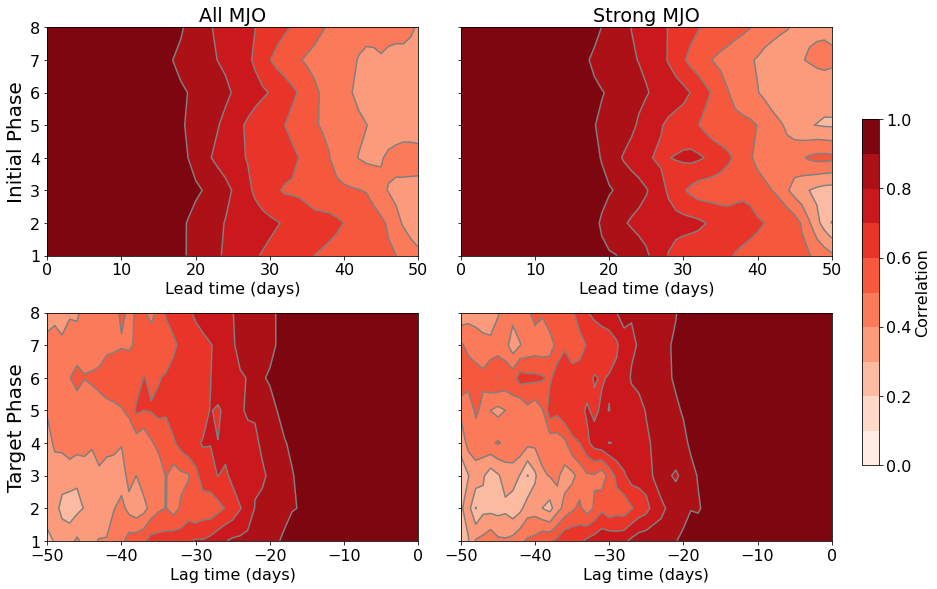

In [163]:
fig,ax = plt.subplots(2,2,figsize=(12,8), sharey = True)#, gridspec_kw={'width_ratios': [1,1,.1]})
plt.tight_layout()
clevs = np.arange(0,1.1,.1) #ACC
a = ax[0,0].contourf(np.arange(0,51), np.arange(1,9), error_matrix_phase[:,6:-10,0], clevs, cmap=plt.cm.Reds) #ACC
ax[0,0].contour(np.arange(0,51), np.arange(1,9), error_matrix_phase[:,6:-10,0], clevs, colors='grey')
c = ax[0,1].contourf(np.arange(0,51), np.arange(1,9), error_matrix_phase_act[:,6:-10,0], clevs, cmap=plt.cm.Reds) 
ax[0,1].contour(np.arange(0,51), np.arange(1,9), error_matrix_phase_act[:,6:-10,0], clevs, colors='grey')
ax[0,0].set_xlabel('Lead time (days)')
ax[0,1].set_xlabel('Lead time (days)')

a2 = ax[1,0].contourf(bicor_rmse_info.lag[:-10], bicor_rmse_info.phase[1:], bicor_rmse_info.acc.sel(phase=slice(1,9),strength='all',lag=slice(0,-50)), clevs, cmap=plt.cm.Reds) #ACC
ax[1,0].contour(bicor_rmse_info.lag[:-10], bicor_rmse_info.phase[1:], bicor_rmse_info.acc.sel(phase=slice(1,9),strength='all',lag=slice(0,-50)), clevs, colors='grey')
r2 = ax[1,1].contourf(bicor_rmse_info.lag[:-10], bicor_rmse_info.phase[1:], bicor_rmse_info.acc.sel(phase=slice(1,9),strength='strong',lag=slice(0,-50)), clevs, cmap=plt.cm.Reds) 
ax[1,1].contour(bicor_rmse_info.lag[:-10], bicor_rmse_info.phase[1:], bicor_rmse_info.acc.sel(phase=slice(1,9),strength='strong',lag=slice(0,-50)), clevs, colors='grey')

# add_axes([xmin,ymin,dx,dy])
cbar_ax = fig.add_axes([1, .2, 0.02, .6])
cbar = fig.colorbar(a, cax=cbar_ax, shrink=0.6)
cbar.set_label('Correlation')
ax[1,0].set_xlabel('Lag time (days)')
ax[1,1].set_xlabel('Lag time (days)')
ax[0,0].set_ylabel('Initial Phase', fontsize=20)
ax[1,0].set_ylabel('Target Phase', fontsize=20)

ax[0,0].set_title('All MJO')
ax[0,1].set_title('Strong MJO')
plt.subplots_adjust(hspace=.25)
#plt.savefig(fig_dir / 'predict_fig4.svg', bbox_inches='tight', format = 'svg', dpi=1200)
#plt.savefig(fig_dir / 'predict_fig4.png', bbox_inches='tight')

37
39
36


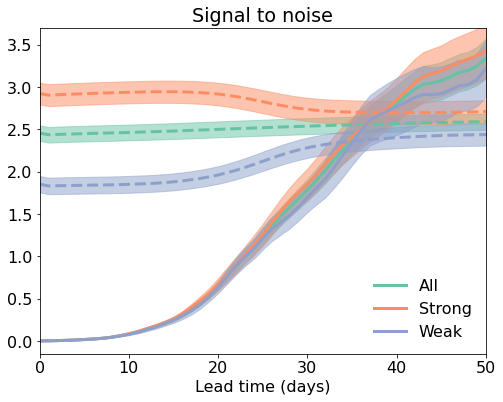

In [167]:
# plot signal and noise by active/inactive

print(np.where(mse.mean(axis=1) > signal.mean(axis=1))[0][0] - 6)
print(np.where(mse_active.mean(axis=1) > signal_active.mean(axis=1))[0][0] - 6)
print(np.where(mse_inactive.mean(axis=1) > signal_inactive.mean(axis=1))[0][0] - 6)

fig = plt.figure(figsize=(8,6))
plt.plot(mse[6:-10].mean(axis=1), label='All', color=color_set[0], linewidth=3)
plt.plot(signal[6:-10].mean(axis=1), linestyle='--', color=color_set[0], linewidth=3)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(signal[6:-10],798)[0], calculate_ci_signal(signal[6:-10],798)[1], color=color_set[0], alpha=0.5)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(mse[6:-10],798)[0], calculate_ci_signal(mse[6:-10],798)[1], color=color_set[0], alpha=0.5)

plt.plot(mse_active[6:-10].mean(axis=1), label='Strong', color=color_set[1], linewidth=3)
plt.plot(signal_active[6:-10].mean(axis=1), linestyle='--', color=color_set[1], linewidth=3)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(signal_active[6:-10],450)[0], calculate_ci_signal(signal_active[6:-10],450)[1], color=color_set[1], alpha=0.5)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(mse_active[6:-10],450)[0], calculate_ci_signal(mse_active[6:-10],450)[1], color=color_set[1], alpha=0.5)

plt.plot(mse_inactive[6:-10].mean(axis=1), label='Weak', color=color_set[2], linewidth=3)
plt.plot(signal_inactive[6:-10].mean(axis=1), linestyle='--', color=color_set[2], linewidth=3)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(signal_inactive[6:-10],348)[0], calculate_ci_signal(signal_inactive[6:-10],348)[1], color=color_set[2], alpha=0.5)
plt.fill_between(np.arange(0,51), romi.calculate_ci_signal(mse_inactive[6:-10],348)[0], calculate_ci_signal(mse_inactive[6:-10],348)[1], color=color_set[2], alpha=0.5)


plt.legend(frameon=False)
plt.title('Signal to noise')
plt.xlabel('Lead time (days)')
plt.ylim([-.15,3.7])
plt.xlim([0,50])
#plt.savefig(fig_dir / 'predict_fig5.svg', bbox_inches='tight', format = 'svg', dpi=1200)
#plt.savefig(fig_dir / 'predict_fig5.png', bbox_inches='tight')

In [ ]:
def split_restarts_by_phase_initial(ROMI_data, threshold=1.14, threshold_window=0):
    """
    Separate restart dates by phase and activity. Can adjust thresholding for active MJOs.

    :param restart_dates: total list of restarts to sort
    :param output_path: Path object to restart directory
    :param threshold: integer of ROMI amplitude to use for active MJO events. Default = 1.
    :param threshold_window: number of days before and and after restart date to use for determining
    whether an MJO event is active or not. Default is 2 days, meaning we use a 5-day window with an 
    average amplitude above :param threshold: to classify the event as active. 

    :returns: list of lists for all events, sorted into 8 phases, and active events, sorted into 8 phases. 
    Length of list = 8, where each element corresponds to the dates in that phase. 
    """

    sorted_phase = [ [] for _ in range(8) ]
    sorted_act = [ [] for _ in range(8) ]

    for idx in range(len(ROMI_data.nruns)):
        
        # find phase at restart date
        phase_n = int(ROMI_data.Phase.sel(nruns=idx,leadlag=0)) - 1
        sorted_phase[phase_n].append(str(ROMI_data.restart_date.sel(nruns=idx).values))
        # determine if restart date is during an active MJO
        if np.mean(ROMI_data.Amplitude.sel(nruns=idx, leadlag=slice(0-threshold_window:0+threshold_window+1)) > threshold): # need longer ROMI saved
            sorted_act[phase_n].append(str(ROMI_data.restart_date.sel(nruns=idx).values))

    return sorted_phase, sorted_act